Epoch 0, Loss: 1392022781952.0000


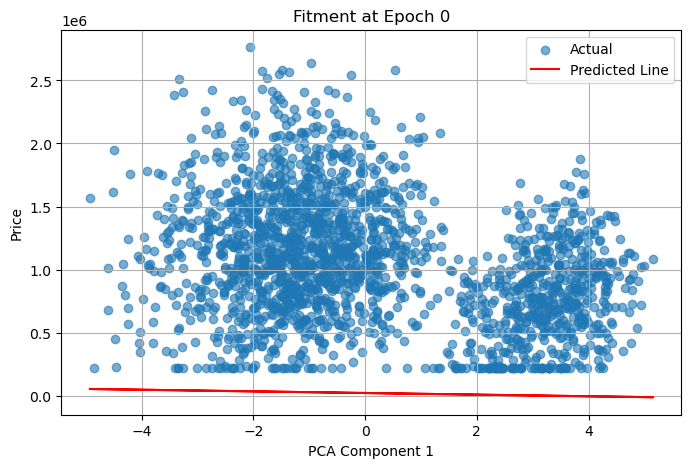

Epoch 1000, Loss: 226535047168.0000


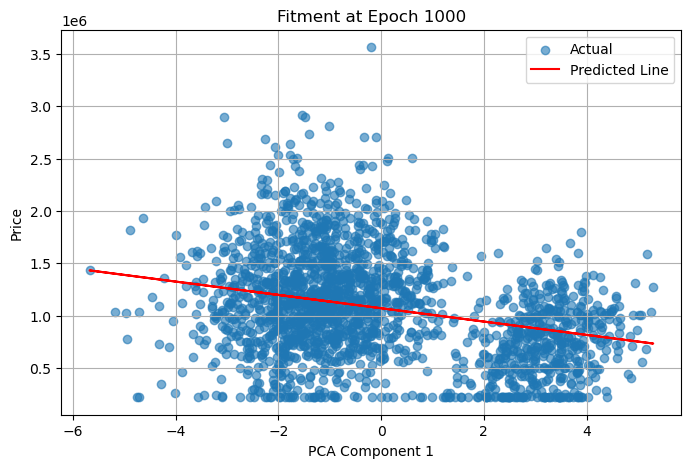

Epoch 2000, Loss: 226535047168.0000


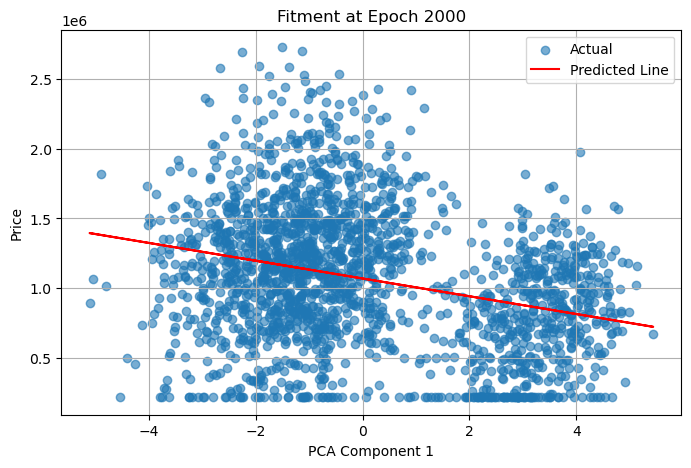

Epoch 3000, Loss: 226535047168.0000


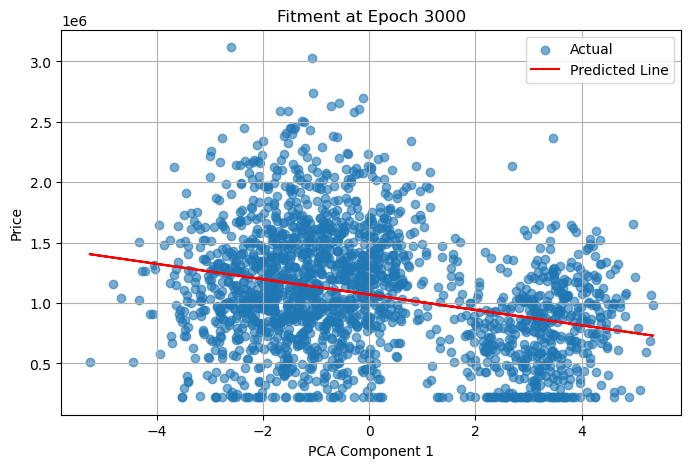

Epoch 4000, Loss: 226535047168.0000


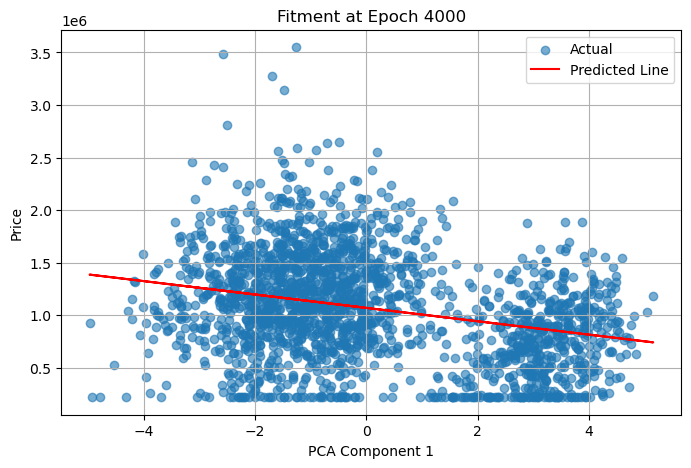

Epoch 5000, Loss: 226535047168.0000


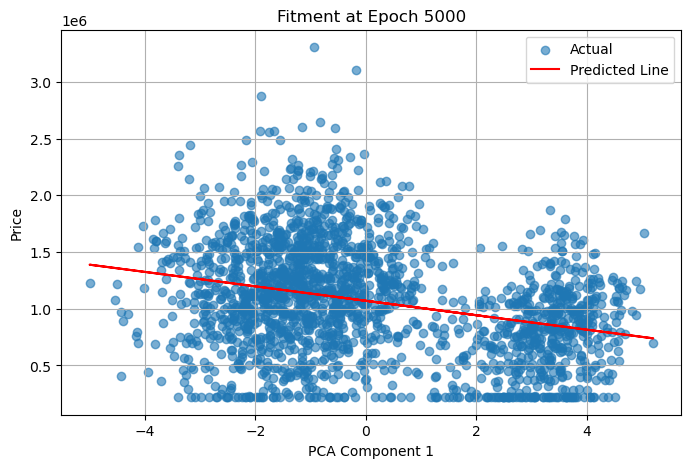

Epoch 6000, Loss: 226535047168.0000


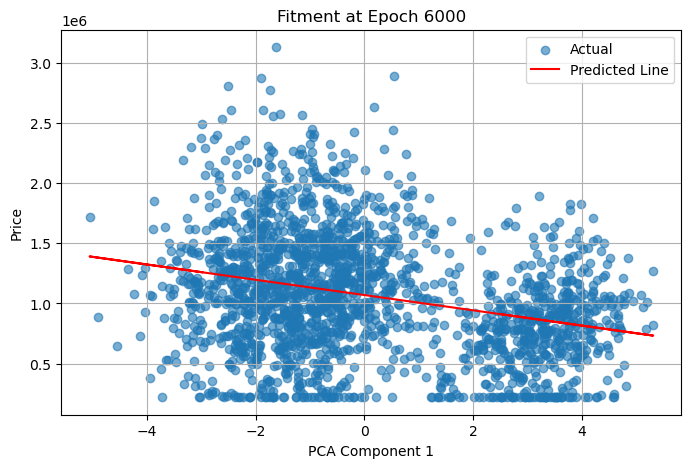

Epoch 7000, Loss: 226535047168.0000


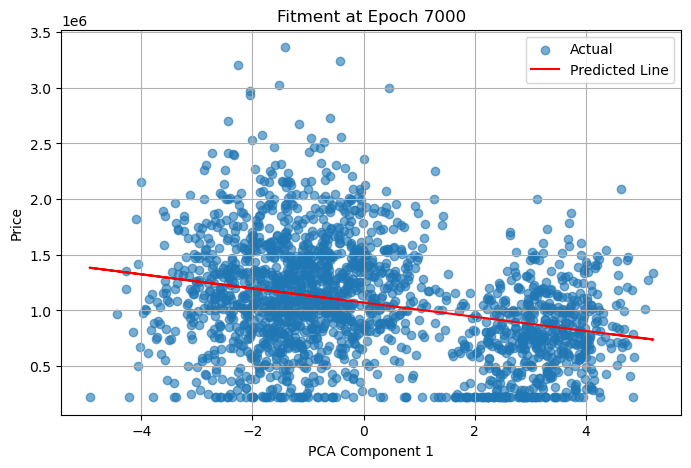

Epoch 8000, Loss: 226535047168.0000


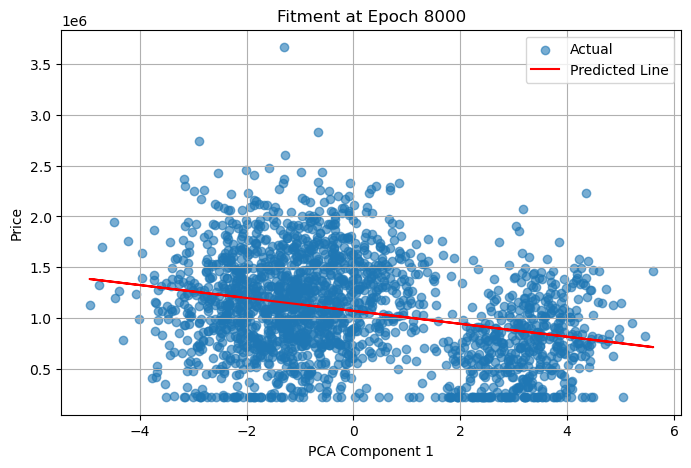

Epoch 9000, Loss: 226535047168.0000


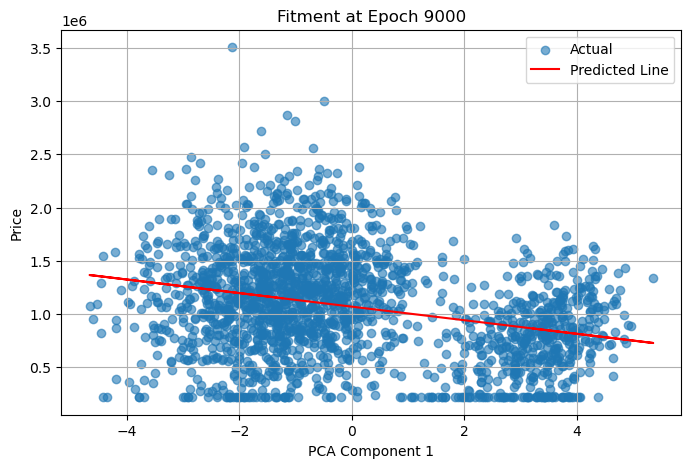

✅ Model trained and saved to 'manual_house_price_model_pca.pkl'


In [5]:

import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# 🔄 Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 📥 Load dataset
df = pd.read_csv("house_prices_au.csv")  # Path to your generated data

# 🎯 Target
y_np = df["price"].values

# 🔢 One-hot encode categoricals & drop target
categoricals = ["city", "state", "property_type"]
X_encoded = pd.get_dummies(df.drop(columns=["price"]),
                           columns=categoricals,
                           drop_first=True)

# 📏 Standardize features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# 🧠 Reduce to 1D with PCA
pca = PCA(n_components=1)
X_pca_np = pca.fit_transform(X_scaled)

# 🔁 Convert to tensors
X = torch.tensor(X_pca_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32).view(-1, 1)

# 🔢 Parameters for manual regression
W = torch.randn(1, 1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

# 📉 MSE loss
def mse(pred, target):
    return torch.mean((pred - target) ** 2)

# 📊 Plot helper
def plot_fit(epoch, X, y, W, b, sample_size=2000):
    with torch.no_grad():
        if len(X) > sample_size:
            idx = torch.randperm(len(X))[:sample_size]
            X_plot, y_plot = X[idx], y[idx]
        else:
            X_plot, y_plot = X, y

        x_vals = X_plot[:, 0].numpy()
        y_vals = y_plot.numpy().flatten()
        y_pred = (X_plot @ W + b).numpy().flatten()

        plt.figure(figsize=(8, 5))
        plt.scatter(x_vals, y_vals, alpha=0.6, label="Actual")
        plt.plot(x_vals, y_pred, color="red", label="Predicted Line")
        plt.title(f"Fitment at Epoch {epoch}")
        plt.xlabel("PCA Component 1")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.show()

# 🏋️ Train loop
lr = 0.01
epochs = 10_000

for epoch in range(epochs):
    y_pred = X @ W + b
    loss = mse(y_pred, y)
    loss.backward()

    with torch.no_grad():
        W -= lr * W.grad
        b -= lr * b.grad
        W.grad.zero_()
        b.grad.zero_()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        plot_fit(epoch, X, y, W, b)

# 💾 Save model + transforms
model_params = {
    "W": W.detach(),
    "b": b.detach(),
    "scaler_mean": scaler.mean_,
    "scaler_scale": scaler.scale_,
    "pca_mean": pca.mean_,
    "pca_components": pca.components_,
    "columns": X_encoded.columns.tolist()
}
with open("manual_house_price_model_pca.pkl", "wb") as f:
    pickle.dump(model_params, f)

print("✅ Model trained and saved to 'manual_house_price_model_pca.pkl'")

